Compares annotations from different experts



In [1]:
# @author: barisbozkurt
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import agreement
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# This code consumes data files created by the dataProcessPipeline.py script

# Unpacking data from different annotators with and without manually corrected onsets
data_packages = ['rhythm_data4ML_0.zip','rhythm_data4ML_1.zip','rhythm_data4ML_2.zip']

data_folders = ['Expert0','Expert1','Expert2']

#Unzipping packages into folders
for data_folder, data_zip_file in zip(data_folders, data_packages):
  if not os.path.exists(data_folder):  # create folder if not exists
      os.mkdir(data_folder)
  zip_ref = zipfile.ZipFile(data_zip_file, 'r')
  zip_ref.extractall(data_folder)
  zip_ref.close()

In [3]:
def read_tabular_data(data_folder, train_file_path='trainData.csv', test_file_path='testData.csv'):
  '''Reads tabular data and converts to dictionaries'''
  trainDF = pd.read_csv(os.path.join(data_folder, train_file_path))
  testDF = pd.read_csv(os.path.join(data_folder, test_file_path))
  y_train = trainDF[['Per_file','grade']].to_dict(orient='records')
  y_test = testDF[['Per_file','grade']].to_dict(orient='records')
  
  # Conversion from DF to dictionary
  y_train_dict = {}
  for k in range(len(y_train)):
    y_train_dict[y_train[k]['Per_file']] = y_train[k]['grade']
  
  y_test_dict = {}
  for k in range(len(y_test)):
    y_test_dict[y_test[k]['Per_file']] = y_test[k]['grade']
  
  y_all_dict = {**y_train_dict, **y_test_dict} # merge two dictionaries

  return y_train_dict, y_test_dict, y_all_dict

In [7]:
def report_comparison(data_folder_a, data_folder_b, annot_dict_a, annot_dict_b, labels, comp_type):

  # The file set may both be exactly the same, so we pick from one and search 
  #  in the other and include if file exists in both 
  annots_a = []
  annots_b = []
  for file_a in annot_dict_a.keys():
    if file_a in annot_dict_b: 
      annots_a.append(annot_dict_a[file_a])
      annots_b.append(annot_dict_b[file_a])

  annots_a = np.array(annots_a);annots_b = np.array(annots_b)

  conf_mat = pd.DataFrame(confusion_matrix(annots_a, annots_b),
                            columns=labels, index=labels)
  conf_mat.index.name = 'Annots. by ' + data_folder_a
  conf_mat.columns.name = 'Annots. by ' + data_folder_b
  
  plt.figure(figsize=(7, 5))
  sns.set(font_scale=1.2)
  sns.heatmap(conf_mat, cmap='Blues', annot_kws={'size': 12}, annot=True)
  plt.title('{} vs {} on {} files of {}'.format(data_folder_a, data_folder_b, comp_type, data_folder_a))

  # Compute MAE
  MAE = np.sum(np.abs(annots_a - annots_b)) / annots_a.size
  print('MAE on {} data {} vs {}: {}'.format(comp_type, data_folder_a, data_folder_b, MAE))

  # Print classification-type comparison
  print(classification_report(annots_a, annots_b, target_names=labels_str))

  # Compute agreement coefficients
  formatted_codes = [[1,i,annots_a[i]] for i in range(len(annots_a))] + [[2,i,annots_b[i]] for i in range(len(annots_b))]  

  # Rating computation using https://www.nltk.org/_modules/nltk/metrics/agreement.html 
  ratingtask = agreement.AnnotationTask(data=formatted_codes)
  print("Krippendorff's Alpha:", ratingtask.alpha())
  print("Cohen's Kappa:", ratingtask.kappa())
  print('-'*40)

In [8]:
# Computing agreement coefficients for all labels
# Rating computation using https://www.nltk.org/_modules/nltk/metrics/agreement.html 
_ , _ , y_all_dict_a = read_tabular_data(data_folders[0])
_ , _ , y_all_dict_b = read_tabular_data(data_folders[1])
_ , _ , y_all_dict_c = read_tabular_data(data_folders[2])

annots_a = []
annots_b = []
annots_c = []
for file_a in y_all_dict_a.keys():
  if file_a in y_all_dict_b and file_a in y_all_dict_c:
    annots_a.append(y_all_dict_a[file_a])
    annots_b.append(y_all_dict_b[file_a])
    annots_c.append(y_all_dict_c[file_a])

# Compute agreement coefficients
formatted_codes = [[1,i,annots_a[i]] for i in range(len(annots_a))] + [[2,i,annots_b[i]] for i in range(len(annots_b))] + [[3,i,annots_c[i]] for i in range(len(annots_c))]  

ratingtask = agreement.AnnotationTask(data=formatted_codes)
print("Davies and Fleiss 1982 Kappa:", ratingtask.multi_kappa())

Davies and Fleiss 1982 Kappa: 0.4874809457059146


########################################
COMPARING ANNOTATIONS OF  Expert0 and Expert1 over files of Expert0
MAE on ALL data Expert0 vs Expert1: 0.5043310875842156
              precision    recall  f1-score   support

           1       0.71      0.50      0.59       230
           2       0.48      0.28      0.35       200
           3       0.52      0.54      0.53       283
           4       0.69      0.98      0.81       326

    accuracy                           0.62      1039
   macro avg       0.60      0.58      0.57      1039
weighted avg       0.61      0.62      0.60      1039

Krippendorff's Alpha: 0.4719621807228528
Cohen's Kappa: 0.4766243703373078
----------------------------------------
MAE on TEST data Expert0 vs Expert1: 0.63
              precision    recall  f1-score   support

           1       0.62      0.52      0.57        25
           2       0.43      0.24      0.31        25
           3       0.43      0.48      0.45        25
           4       0.59   

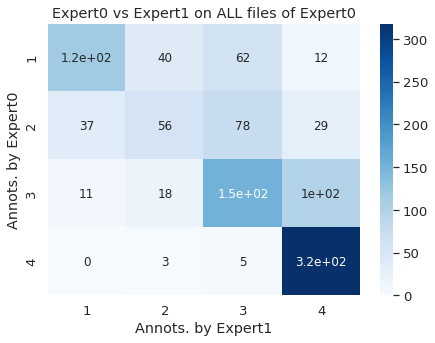

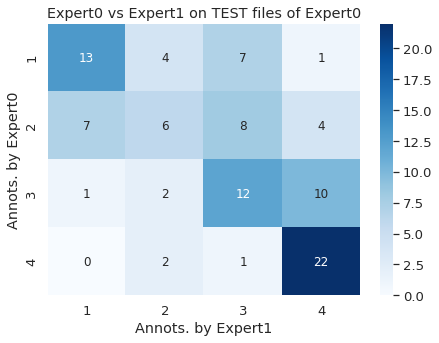

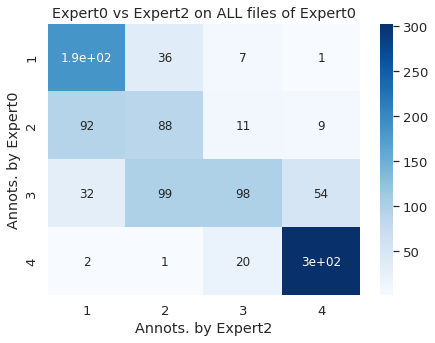

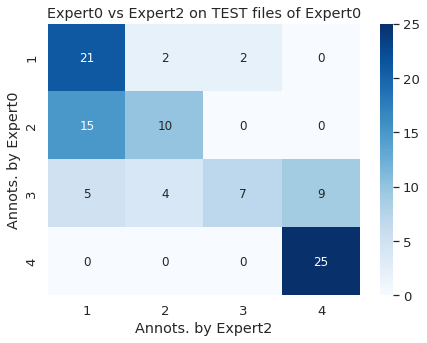

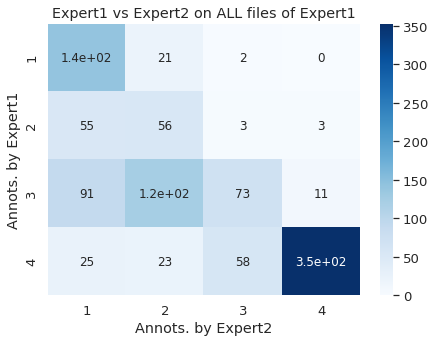

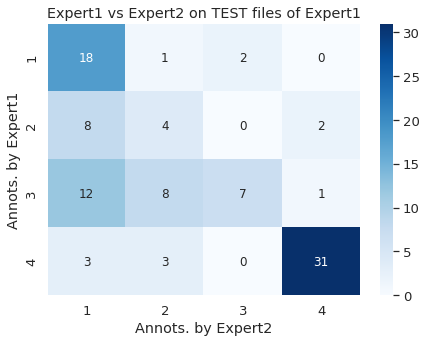

In [9]:
# Comparison combinations
data_folder_combinations = [(data_folders[0],data_folders[1]),
                            (data_folders[0],data_folders[2]),
                            (data_folders[1],data_folders[2])]
labels = np.arange(1,5)
labels_str = [str(val) for val in labels]

for data_folder_a, data_folder_b in data_folder_combinations:
  print('#'*40)
  print('COMPARING ANNOTATIONS OF ', data_folder_a, 'and', data_folder_b, 'over files of', data_folder_a)

  # Read train and test file annotations, merge to get all annots
  y_train_dict_a, y_test_dict_a, y_all_dict_a = read_tabular_data(data_folder_a)
  y_train_dict_b, y_test_dict_b, y_all_dict_b = read_tabular_data(data_folder_b)

  # Comparing annotations for all files of annotator-a over annotator-b
  report_comparison(data_folder_a, data_folder_b, y_all_dict_a, y_all_dict_b, labels, 'ALL')
  
  # Comparing annotations for train files of annotator-a over annotator-b
  # report_comparison(data_folder_a, data_folder_b, y_train_dict_a, y_train_dict_b, labels, 'train')

  # Comparing annotations for test files of annotator-a over annotator-b
  report_comparison(data_folder_a, data_folder_b, y_test_dict_a, y_test_dict_b, labels, 'TEST')
